## Ejercicio practico NLP

1. Crear un clasificador de noticias falsas o verdaderas. Partimos de un dataset con noticias en inglés.
2. Análisis de tópicos de las noticias en linea temporal

**Clasificador**
Lo primero que hacemos es limpiar los datos, tokennizar y lematizar para trasnformar el texto en las palabras que introduciremos al modelo. En este caso una red neuronal que suelo utilizar para este tipo de problemas, me ayuda a haya buenos resultados.

**Analisis de tópicos**
Para analizar los tópicos utilizamos los mismos datos, partiendo de un conjunto de texto ya procesado y tokenizado aplicamos un modelo BTM para hayar los BITERMS y agrupar por cada uno de los tópicos.

## Librerias

In [38]:
import re, string
import pandas as pd
from tqdm import tqdm

import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split
import tensorflow.keras.backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Embedding,Conv1D,MaxPooling1D,LSTM
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report
import seaborn as sns

### Datos

Cargamos los datos en formato CSV. Los datos se han descargado de CUNEF. El archivo contiene noticias con una clasificación.
Para la práctica unicamente vamos a utilizar el cuerpo de la noticia. Aunque es interesante considerar la posibilidad de unir ambos textos para procesar el título de la noticia, el cual puede contener información y palabras clave para determinar si la noticia es flasa o no.

Por el momento vamos a utilizar únicamente el cuerpo. Confiamos en que nos proporcione la suficiente información.

In [39]:
news = pd.read_csv('/content/fake_or_real_news.csv')
news = news.drop(columns='Unnamed: 0')
print(news.shape)
news.head()

(6335, 3)


,title,text,label
0,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE
1,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE
2,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL
3,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE
4,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL


Cambiamos el formato de la variable target definiendo la siguiente función y aplicandola a la ya existente variable label de los datos.

In [40]:
def news_label(label):
    if label == 'FAKE':
        return 0
    else:
        return 1

In [41]:
news['label'] = news.label.apply(lambda x: news_label(x))

### Limpieza del texto

La siguiente celda elimina del texto los links y las paginas webs, ademas de quitar la puncuación que definimos con la siguiente función:

In [ ]:
def remove_punctuation ( text ):
  return re.sub('[%s]' % re.escape(string.punctuation), ' ', text)

In [42]:
dd = news.copy()

for i, s in enumerate(tqdm(dd['text'], position=0, leave=True)):
    text = str(dd.loc[i, 'text'])
    text = re.sub('https?://(?:[-\w.]|(?:%[\da-fA-F]{2}))+', '', text, flags=re.MULTILINE)
    text = re.sub('@\\w+ *', '', text, flags=re.MULTILINE)
    text = text.apply(lambda x: remove_punctuation(x))
    dd.loc[i, 'text'] = text

100%|██████████| 6335/6335 [00:12<00:00, 518.96it/s]


In [95]:
y = pd.get_dummies(dd['label']).values
X = dd['text']
num_classes = dd['label'].nunique()
seed=39
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2,
                                                    stratify=y,
                                                    random_state=seed)

# shapes
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(5068,) (1267,) (5068, 2) (1267, 2)


### Evaluación del modelo

Definimos la siguiente formula para evaluar nuestro modelo posteriormente:

In [96]:
def f1_score(precision, recall):
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

### Tokenización del texto

In [98]:
max_features = 20000
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(X_train))
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

### Secuencia

In [100]:
max_words = 30
X_train = sequence.pad_sequences(X_train, maxlen=max_words)
X_test = sequence.pad_sequences(X_test, maxlen=max_words)
print(X_train.shape,X_test.shape)

(5068, 30) (1267, 30)


## Modelo de Red Neuronal Sequencial

In [107]:
batch_size = 100
epochs = 50

max_features = 20000
embed_dim = 100

np.random.seed(seed)
K.clear_session()
model = Sequential()
model.add(Embedding(max_features, embed_dim, input_length=X_train.shape[1]))
model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))    
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(2, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 30, 100)           2000000   
                                                                 
 conv1d (Conv1D)             (None, 30, 32)            9632      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 15, 32)           0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 15, 32)            3104      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 7, 32)            0         
 1D)                                                             
                                                                 
 lstm (LSTM)                 (None, 100)               5

### Entrenamiento del modelo

In [108]:
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), 
                          epochs=epochs, batch_size=batch_size)

Epoch 1/50
51/51 [==============================] - 7s 82ms/step - loss: 0.6473 - accuracy: 0.6101 - val_loss: 0.4626 - val_accuracy: 0.7743
Epoch 2/50
51/51 [==============================] - 3s 61ms/step - loss: 0.3048 - accuracy: 0.8735 - val_loss: 0.3671 - val_accuracy: 0.8256
Epoch 3/50
51/51 [==============================] - 3s 62ms/step - loss: 0.0692 - accuracy: 0.9783 - val_loss: 0.6339 - val_accuracy: 0.8066
Epoch 4/50
51/51 [==============================] - 3s 62ms/step - loss: 0.0129 - accuracy: 0.9970 - val_loss: 0.7465 - val_accuracy: 0.8090
Epoch 5/50
51/51 [==============================] - 3s 62ms/step - loss: 0.0033 - accuracy: 0.9992 - val_loss: 0.9428 - val_accuracy: 0.8011
Epoch 6/50
51/51 [==============================] - 3s 61ms/step - loss: 0.0020 - accuracy: 0.9996 - val_loss: 1.1696 - val_accuracy: 0.8003
Epoch 7/50
51/51 [==============================] - 3s 61ms/step - loss: 0.0063 - accuracy: 0.9976 - val_loss: 1.0792 - val_accuracy: 0.7853
Epoch 8/50
51

### Validación y Loss

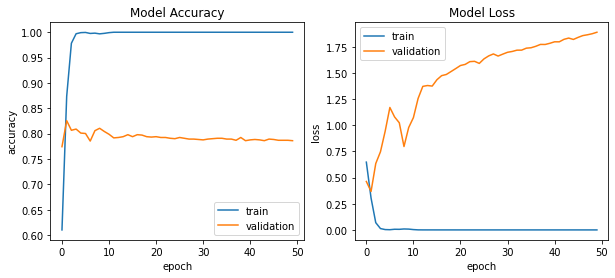

In [109]:
def plot_training_hist(history):
    '''Function to plot history for accuracy and loss'''
    
    fig, ax = plt.subplots(1,2, figsize=(10,4))
    # first plot
    ax[0].plot(history.history['accuracy'])
    ax[0].plot(history.history['val_accuracy'])
    ax[0].set_title('Model Accuracy')
    ax[0].set_xlabel('epoch')
    ax[0].set_ylabel('accuracy')
    ax[0].legend(['train', 'validation'], loc='best')
    
    # second plot
    ax[1].plot(history.history['loss'])
    ax[1].plot(history.history['val_loss'])
    ax[1].set_title('Model Loss')
    ax[1].set_xlabel('epoch')
    ax[1].set_ylabel('loss')
    ax[1].legend(['train', 'validation'], loc='best')
    
plot_training_hist(history)

### Resultados predicción clasificación

In [110]:
# predict class with test set
y_pred_test =  np.argmax(model.predict(X_test), axis=1)
print('Accuracy:\t{:0.1f}%'.format(accuracy_score(np.argmax(y_test,axis=1),y_pred_test)*100))
print(classification_report(np.argmax(y_test,axis=1), y_pred_test))

Accuracy:	78.6%
              precision    recall  f1-score   support

           0       0.80      0.76      0.78       633
           1       0.77      0.81      0.79       634

    accuracy                           0.79      1267
   macro avg       0.79      0.79      0.79      1267
weighted avg       0.79      0.79      0.79      1267



### Matriz de confusión problema binario

1    634
0    633
dtype: int64
1    667
0    600
dtype: int64


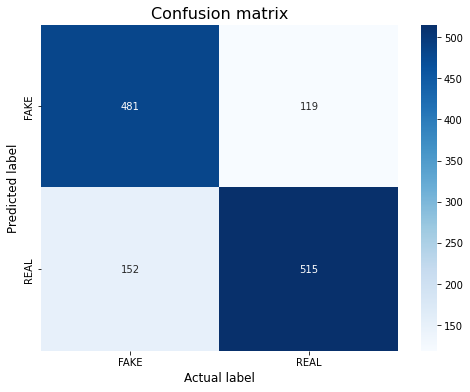

In [111]:
def plot_confusion_matrix(model, X_test, y_test):
    '''Function to plot confusion matrix for the passed model and the data'''
    
    sentiment_classes = ['FAKE','REAL']
    # use model to do the prediction
    y_pred = model.predict(X_test)
    # compute confusion matrix
    cm = confusion_matrix(np.argmax(y_pred, axis=1),np.argmax(np.array(y_test),axis=1))
    
    print(pd.Series(np.argmax(np.array(y_test),axis=1)).value_counts())
    print(pd.Series(np.argmax(y_pred, axis=1)).value_counts())
    
    # plot confusion matrix
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, cmap=plt.cm.Blues, annot=True, fmt='d', 
                xticklabels=sentiment_classes,
                yticklabels=sentiment_classes)
    plt.title('Confusion matrix', fontsize=16)
    plt.xlabel('Actual label', fontsize=12)
    plt.ylabel('Predicted label', fontsize=12)
    
plot_confusion_matrix(model, X_test, y_test)